# Assignment 3 

# Table of Content

## Data Exploration
1. People's Behavior in terms of Dwell Time 
2. Which areas of 307 do people pass through
3. Where do people tend to linger?
4. How does dwell time change over time?

## In-depth Analysis
1. How do different zones affect people's behavior?
2. How do events affect people's behavior?
3. What is the best maintenance strategy?
4. What are other factor affect people's bahavior?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

In [2]:
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
#init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(colorscale='plotly', world_readable=True)

# Extra options
# pd.options.display.max_rows = 30
# pd.options.display.max_columns = 25

# Show all code cells outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import os
from IPython.display import Image, display, HTML

In [3]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [4]:
# store login data in login.py
%run login.py

In [5]:
# login query as multiline formatted string
# this assumes that login and pwd are defined 
# above

loginquery = f"""
mutation {{
  logIn(
      email:\"{login}\",
      password:\"{pwd}\") {{
    jwt {{
      token
      exp
    }}
  }}
}}
"""

In [6]:
import requests
url = 'https://api.numina.co/graphql'

mylogin = requests.post(url, json={'query': loginquery})
# mylogin

In [7]:
token = mylogin.json()['data']['logIn']['jwt']['token']

In [8]:
expdate = mylogin.json()
# expdate

# Context and Preview

The following images present the areas covered by the three devices/cameras:

Streetscape | Under Raincoat | Outside
------------- | -------------  | -------------
![alt](streetscape_sandbox.png) | ![alt](underraincoat_sandbox.png) | ![alt](outside_sandbox.png)

As you see in the above images, each area essentially consists of two parts: objects such as tables and chairs, and empty spaces presumably for walking. Based on this reasoning, we have defined the following smaller behaviour zones so as to perform more in-depth research:

### Streetscape ###

Chair Zone | Corridor Zone | Free Zone
------------- | -------------  | -------------
![alt](BehaviorZoneImage/Streetscape-ChairZone.png) | ![alt](BehaviorZoneImage/Streetscape-PathZone.png) | ![alt](BehaviorZoneImage/Streetscape-ActivityZone.png)

### Under Raincoat ###

Chair Zone | Traffic Zone | Free Zone
------------- | -------------  | -------------
![alt](BehaviorZoneImage/UnderRaincoat-ChairZone.png) | ![alt](BehaviorZoneImage/UnderRaincoat-TrafficZone.png) | ![alt](BehaviorZoneImage/UnderRaincoat-ActivityZone.png)

### Outside ###

Chair Zone | Path Zone | -
------------- | -------------  | -------------
![alt](BehaviorZoneImage/Outside-ChairZone.png) | ![alt](BehaviorZoneImage/Outside-PathZone.png) | ![alt](blank.png)

Note that we have to be aware of the fact that the chairs can be moved and that the above images may not necessarily reflect the layout of the room during the whole period of data collection. Specifically, the three sets of chairs in the Under Raincoat area can be easily moved. Thus, for the purpose of this webpage, we will not be investigating the Chair Zone of Under Raincoat; instead, we will integrate any analysis of the chairs into the analysis of the Free Zone, since it is presumably safe to assume that the chairs would not be moved outside the Free Zone to the Traffic Zone.

Similarly, in the Streetscape area, under the assumption that it is intended to place the chairs together, it is unlikely that the group of chairs would be moved around freely and frequently due to the other obstacles in the room. As for the Outside area, it is also unlikely that the chairs would be placed in the middle of the road to block the path. Thus, we will be analyzing these two Chair Zones (while keeping the limitation in mind).

# Patterns in Pedestrian Count and Dwell Time

In [9]:
# device info
device_dict = {'SWLSANDBOX1':'Streetscape', 'SWLSANDBOX2':'Under Raincoat', 'SWLSANDBOX3':'Outside'}
device_ids = list(device_dict.keys())
device_names = list(device_dict.values())

In [10]:
def get_zones(device_id):
    '''
    a query to get all zones within the areas included in the device_id list;
    returns a df
    '''
    query_zones = """
    query {{
      behaviorZones (
        serialnos: "{0}"
        ) {{
        count
        edges {{
          node {{
            rawId
            text
          }}
        }}
      }}
    }}
    """.format(device_id)
    
    zones = requests.post(url, json={'query': query_zones}, headers = {'Authorization':token})
    
    df = pd.DataFrame([x['node'] for x in zones.json()['data']['behaviorZones']['edges']])
    df['device_id'] = device_id
    
    return df

In [11]:
# creates a df for zones

# get zones
zones_df = pd.concat([get_zones(device_ids[i]) for i in range(3)])
zones_df = zones_df[(zones_df.text.notnull()) & 
                    (zones_df.text.str.startswith('x-')) & 
                    (zones_df.text.str.endswith('zone'))]

In [12]:
# adjusts zone info

# modify zone name and add a type
zones_df['text'] = zones_df['text'].str.replace('x-', '')
zones_df['type'] = ['path', 'rest', 'both', 'path', 'both', 'rest', 'path']

# colour of zones - 3 blues, 2 reds, 2 greens
zone_clrs = ['royalblue', 'deepskyblue', 'dodgerblue',
             'lightcoral', 'orangered', 
             'mediumaquamarine', 'mediumseagreen']

# zone ID from int to str
zones_df.rawId = zones_df.rawId.astype(str)
zone_name_dict = dict(zip(zones_df.rawId, zones_df.text))
zone_type_dict = dict(zip(zones_df.rawId, zones_df.type))

In [13]:
def get_dwell(func, ID, interval):
    '''
    func is either feedDwellTimeDistribution or zoneDwellTimeDistribution;
    a query to get dwell info in area/zone identified by ID;
    returns a preprocessed dataframe
    '''
    if func == 'feedDwellTimeDistribution':
        arg = 'serialnos: "{0}"'.format(ID)
    else:
        arg = 'zoneIds: {0}'.format(ID)
        
    query = """
    query {{
        {0}(
        {1},
        startTime: "2019-02-20T00:00:00",
        endTime: "2020-01-12T00:00:00",
        timezone: "America/New_York",
        objClasses: ["pedestrian"],
        interval: "{2}"
        ){{
        edges {{
          node {{
            time
            objClass
            pct100
            pct75
            pct50
            pct25
            mean
            count
          }}
        }}
      }}
    }}
    """.format(func, arg, interval)

    dwell = requests.post(url, json={'query': query}, 
                           headers = {'Authorization':token})
    
    # traverse to only keep useful info
    df = pd.DataFrame([x['node'] for x in dwell.json()['data'][func]['edges']])
    # add a column
    if func == 'feedDwellTimeDistribution':
        df['device_id'] = ID
    else:
        df['zone_id'] = ID
    
    return df

In [14]:
def preprocess(df):
    '''
    preprocesses a dataframe returned by feedDwellTimeDistribution/zoneDwellTimeDistribution
    '''
    # replace NaN with 0
    df = df.fillna(0)
    # convert time
    df['time'] = df['time'].str[:-6].apply(lambda x : pd.Timestamp(x))
    df['month'] = df['time'].dt.month
    df['dayofweek'] = df['time'].dt.dayofweek
    df['hour'] = df['time'].dt.hour
    df['date'] = df['time'].dt.date
    
    # add either zone or device name
    if 'zone_id' in df.columns:
        df.zone_id = df.zone_id.astype(str)
        df['zone'] = [zone_name_dict[z] for z in df.zone_id]
        df['zone_type'] = [zone_type_dict[z] for z in df.zone_id]
    else:
        df['device'] = [device_dict[d] for d in df.device_id]
    
    # add a total column = mean * count
    df['total_dwell'] = df['mean'] * df['count']
    df = df.rename(columns={'mean':'mean_dwell', 'pct50':'median_dwell', 'pct100':'max_dwell'})
    df = df.drop(['pct75', 'pct25'], axis=1)
    
    return df

In [15]:
# hourly dwell time 
# device
feed_dwell_1h_df = pd.concat([get_dwell('feedDwellTimeDistribution', device_ids[i], '1h') 
                              for i in range(3)])
# zone
zone_dwell_1h_df = pd.concat([get_dwell('zoneDwellTimeDistribution', z, '1h')
                             for z in zones_df['rawId'].values])
feed_dwell_1h_df = preprocess(feed_dwell_1h_df)
zone_dwell_1h_df = preprocess(zone_dwell_1h_df)

In [16]:
# daily dwell time 
# device
feed_dwell_1d_df = pd.concat([get_dwell('feedDwellTimeDistribution', device_ids[i], '1d') 
                              for i in range(3)])
# zone
zone_dwell_1d_df = pd.concat([get_dwell('zoneDwellTimeDistribution', z, '1d')
                             for z in zones_df['rawId'].values])
feed_dwell_1d_df = preprocess(feed_dwell_1d_df)
zone_dwell_1d_df = preprocess(zone_dwell_1d_df)

In [17]:
def get_df(groupby, interval):
    '''
    helper function to be called by other functions
    '''
    if groupby == 'device' and interval == '1d':
        return feed_dwell_1d_df.copy(), device_names
    elif groupby == 'zone' and interval == '1d':
        return zone_dwell_1d_df.copy(), list(zones_df.text)
    elif groupby == 'device' and interval == '1h':
        return feed_dwell_1h_df.copy(), device_names
    elif groupby == 'zone' and interval == '1h':
        return zone_dwell_1h_df.copy(), list(zones_df.text)

As a starting point, we will use the following interactive line plot to explore the trend in pedesdrian count / dwell time in different areas / zones over the past year. We suggest to focus on comparing across the three areas (i.e. 'groupby' = 'device'). 

Tip: You can click the legend on the right to include/exclude a line on the plot.

In [18]:
metric_list = ['count', 'mean_dwell', 'max_dwell', 'median_dwell', 'total_dwell']

In [19]:
def plot_timeline(groupby, metric):
    '''
    groupby is either 'device' or 'zone';
    metric is a value in metric_list
    '''
    df, _ = get_df(groupby, '1d')
    
    fig = px.line(df, x='time', y=metric, color=groupby, 
                  title='trend in daily pedestrian '+metric+' grouped by '+groupby)
    
    # layout - axes labels
    fig.update_layout(
        xaxis_rangeslider_visible=True
    )
    
    fig.show()
    

In [20]:
_ = interact(plot_timeline, 
             groupby=widgets.RadioButtons(options=['device', 'zone'], value='device'),
             metric=widgets.Dropdown(options=metric_list, value='mean_dwell')
            )

interactive(children=(RadioButtons(description='groupby', options=('device', 'zone'), value='device'), Dropdow…

As a general observation, there is not obvious increasing/decreasing trend (but rather frequent ups and downs) in any of the metric in the past year.

We observe the count (and thus the total dwell time) in the Streetscape area has been siginificantly higher than the other two areas. Meanwhile, we see that peaks in mean dwell time tended to occur in Streetscape, and peaks in max dwell time tended to occur in either Streetscape or Outside. From either perspective, the Under Raincoat area is not as popular.

If you are interested in researching about the reason about the peaks, the following interactive dataframe summarizes the exact locations and dates:

In [21]:
def sort_dwell_1d(groupby, sortby, ascending, top):
    '''
    display a dataframe summarizing the area/zone and times of the top days
    in either descending or ascending order
    '''
    df, _ = get_df(groupby, '1d')
    
    # weekday name
    df['dayofweek'] = df['time'].dt.day_name()
    
    # column list
    cols = [groupby, 'time', 'dayofweek', sortby]
    if sortby == 'count':
        cols.append('mean_dwell')
    elif sortby == 'mean_dwell':
        cols.append('count')
    else:
        cols.append('count')
        cols.append('mean_dwell')
        
    display(df.sort_values(sortby, ascending=ascending).reset_index(drop=True)
              .loc[:int(top)-1, cols])

_ = interact(sort_dwell_1d, 
             groupby=widgets.RadioButtons(options=['device', 'zone'], value='device'),
             sortby=widgets.Dropdown(options=metric_list, value='mean_dwell'),
             top=widgets.IntSlider(value=5, min=1, max=30, step=1, readout_format='d'),
             ascending=widgets.Checkbox(value=False, description='ascending'))

interactive(children=(RadioButtons(description='groupby', options=('device', 'zone'), value='device'), Dropdow…

If, in addition to general observations, you are also interested in comparing the statistics/distribution of a metric across the three areas (ex. the medians of mean dwell time), the following boxplots would be very useful. As mentioned, we highly recommend to focus on device groups only at this point.

In [22]:
def plot_boxplot(metric):
    '''
    plots box plot distribution of metric in metric list
    '''
    fig = go.Figure()
    
    # by device only
    groupby = 'device'
    df, byvals = get_df(groupby, '1d')
    
    for i in range(len(byvals)):
        # Use x instead of y argument for horizontal plot
        fig.add_trace(go.Box(x=df.loc[df[groupby]==byvals[i], metric], name=byvals[i],
                             boxpoints='outliers', boxmean=True))

    # layout - axes labels
    fig.update_layout(
        xaxis_title=metric,
        xaxis_rangeslider_visible=True,
        title='distribution of pedestrian '+metric+' grouped by device'
    )
    
    fig.show()
    

In [23]:
_ = interact(plot_boxplot, 
             metric=widgets.Dropdown(options=metric_list, value='mean_dwell')
            )

interactive(children=(Dropdown(description='metric', index=1, options=('count', 'mean_dwell', 'max_dwell', 'me…

In [24]:
def plot_byhour(groupby, metric):
    '''
    plots scatter plots of metric grouped by groupby ('device' or 'zone')
    and animated through 24 hour
    '''
    # byhour
    df, byvals = get_df(groupby, '1h')
    
    # filter based on quantiles
    #df = df[(df[metric] <= df[metric].quantile(quantiles[1])) &
    #        (df[metric] >= df[metric].quantile(quantiles[0]))].sort_values('hour')
    
    # plot differently based on whethere device or zone
    title = 'change in '+metric+' over different times of the day, with point size weighted by count'
    # device
    if groupby=='device':
        x = '-'
        fc = 'device'
        # category orders
        co = {groupby:byvals}
        df = df.groupby(['hour', 'device']).median().reset_index()
    # zone
    else:
        df['device'] = df['zone'].apply(lambda x : x.split('-')[0])
        x = 'device'
        fc = 'zone_type'
        # category orders
        co = {'device':device_names, 'zone_type':['path', 'rest', 'both']}
        df = df.groupby(['hour', 'device', 'zone_type']).mean().reset_index()
    
    if metric == 'max_dwell':
        yrange = (0, 200)
    else:
        yrange = (0, 25)
    df['-'] = '-'
    fig = px.scatter(df, x=x, y=metric, color='device', facet_col=fc, size='count',
                     animation_frame='hour', opacity=0.5, size_max=60,
                     title=title, category_orders=co, range_y=yrange)
        
    # labels
    fig.layout.update(showlegend=True)
    fig.update_xaxes(showticklabels=False)
    fig.update_xaxes(title='')
    fig.show()

In [25]:
#_ = interact(plot_byhour, groupby=widgets.RadioButtons(options=['device', 'zone'], value='zone'),
             #metric=widgets.Dropdown(options=metric_list[1:-1], value=metric_list[1]))

As we are working with time series data, it is natural to see the effects of different time groups (ex. hours, weekdays, months). We have obtained daily and hourly data. We decided to use 'mean_dwell' as a representative for dwell time data; then we picked 'hour' and 'dayofweek' for hourly data and 'dayofweek' and 'month' for daily data to create the following matrix:

In [26]:
def plot_scatter_mat(data_type):
    title = f'scatter matrix for {data_type} dwell data grouped by device'
    if data_type == 'daily':
        fig = px.scatter_matrix(feed_dwell_1d_df, ['count', 'mean_dwell', 'month', 'dayofweek'], 
                                color='device', opacity=0.5, title=title)
    else:
        fig = px.scatter_matrix(feed_dwell_1h_df, ['count', 'mean_dwell', 'hour', 'dayofweek'], 
                                color='device', opacity=0.5, title=title)
    fig.show()
        
_ = interact(plot_scatter_mat, data_type=widgets.RadioButtons(options=['hourly', 'daily'], value='hourly'))

interactive(children=(RadioButtons(description='data_type', options=('hourly', 'daily'), value='hourly'), Outp…

We suggest to focus on the subplots in the upper triangle. 

From the hourly data, we observe that 'hour' is a significant factor affecting the number of pedestrians passing through (but we cannot tell whether it is true for the dwell time). As we would expect, counts are mostly 0 early in the morning (e.g. before 6am) and reach the peak in the afternoon. We also observe that the outliers / extreme values in 'hourly count' tended to occur on Saturday in the Streetscape (i.e. indoor) area. 

If we compare and contrast the individual distributions of count and mean_dwell, we see that both are right-skewed. However, the distribution of mean dwell time has a much thinner tail, suggesting that mean dwell time tended to be very similar across different hours and days while the count varies more; meanwhile, only the distribution of count suggests that the Streetscape area is significantly more popular than the other two. As a result, we see that the scatter plot between count and mean_dwell shows an 'L' shape, showing that there did not exist an hour in which both the count and mean dwell time are high. In fact, if you hover over the four points with the highest mean_dwell value, you would see that they all have a count of 1. In addition, the plot suggests a weak to no correlation between the two attributes.

Then if we switch to the daily data, the distributions of the count and the mean dwell time are still right-skewed (but with less variation) and still no obvious correlation is exhibited. Solely based on the above scatterplot, since most points overlap, we cannot conclude that 'month' or 'dayofweek' is an important factor affecting the daily data. 

The scatter matrices aim to provide an overall picture and give some guidance for the directions of further exploration. 

Recall that we observed that 'hour' tended to have an impact on at least pedestrian count and we still need to explore the effects of 'dayofweek' and 'month'. Thus, we recommend to explore the data with the following grouped bar plots, which uses hourly data for the 'hour' time group and daily data for the others:

In [27]:
def plot_avg(groupby, metric, timegroup):
    '''
    plots metric of each groupby ('device' or 'zone') 
    by timegroup ('hour', 'date', 'dayofweek', 'month')
    '''
    # get either 1d or 1h depending on time group
    if timegroup == 'hour':
        df, byvals = get_df(groupby, '1h')
    else:
        df, byvals = get_df(groupby, '1d')
    
    # colours
    if groupby == 'device':
        # default colours
        clr = None
    else:
        clr = zone_clrs
        
    # convert dayofweek
    weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    df['dayofweek'] = [weekdays[w] for w in df['dayofweek']]
    
    # filter out 0 count day/hour
    #m = df.groupby('time').sum()
    #df = df[df['time'].isin(list(m[m['count']!=0].index))]
    # group
    df = df.groupby([timegroup, groupby]).median().reset_index()
    
    # plot
    fig = px.bar(df, x=timegroup, y=metric, color=groupby,
                 category_orders={groupby:byvals, 'dayofweek':list(weekdays.values())}, # order of categories
                 color_discrete_sequence=clr, # colour of devices/zones
                 title='median of pedestrian ' + metric + ' grouped by ' + timegroup + ' and ' + groupby,
                 barmode='group')
    fig.show()

In [28]:
_ = interact(plot_avg, 
             groupby=widgets.RadioButtons(options=['device', 'zone'], value='device'),
             metric=widgets.Dropdown(options=metric_list, value='count'),
             timegroup=widgets.Dropdown(options=['hour', 'dayofweek', 'month'], value='dayofweek'))

interactive(children=(RadioButtons(description='groupby', options=('device', 'zone'), value='device'), Dropdow…

Looking at the median value of daily pedestrian data statistics grouped by weekdays, we observe surprisingly that Saturday is a very special day, in which both the count and (mean/max) dwell time in the Streetscape (indoor) area are significantly less than the other days of the week.

As for 'month', we see that in more than half of the days in Febraury, March, April and May, no pedestrians have been detected in the Outside area; similarly, there were no pedestrians in the Under Raincoat area in more than half of the days in November to March. 

The reasons behind these observations are not clear without further information such as maintenance schedule of the devices/cameras. We highly encourage you to investigate the reasons behind having no visits if the cameras were actually in service. 

On the other hand, it is more reasonable to see the median values of 'count' being all 0 from 11pm to 6am. We observe a normal distribution for the count in the Outside and Under Raincoat areas but a gap between 5pm and 8pm for the Streetscape area. 

Now in place of the exact values of the metrics, let's look at the proportions (in terms of pedestrian count and total dwell time):

In [29]:
from plotly.subplots import make_subplots

def plot_pies():
    '''
    two pie charts on total count and dwell time grouped by device
    '''
    # labels and colours to be consistent
    labels = ['Streetscape', 'Under Raincoat', 'Outside']
    clr = ['#636EFA', '#EF553B', '#00cc96']
    
    # subplots
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
    fig.add_trace(go.Pie(labels=labels, values=[378580, 42054, 101548], marker_colors=clr),
                  1, 1)
    fig.add_trace(go.Pie(labels=labels, values=[8801918.21, 913902.16, 1687283.20], marker_colors=clr),
                  1, 2)

    # `hole` to create a donut-like pie chart
    fig.update_traces(hole=.4, hoverinfo='label+percent')

    fig.update_layout(
        title_text='proportion of total data accounted for by each area',
        # annotations in the center of the donut pies.
        annotations=[dict(text='count', x=0.18, y=0.5, font_size=20, showarrow=False),
                     dict(text='total dwell', x=0.85, y=0.5, font_size=20, showarrow=False)])
    fig.show()
    
plot_pies()

If we consider all data together, then the Streetscape area accounted for about 77.2% of all dwell time in the 307, followed by Outside (14.8%) and Under Raincoat (8%). By comparing the two pie charts, we could also conclude that the dwell time on average tended to be longer in the Under Raincoat area than in the Outside area.

Now let's look at the proportions in more details.

In [30]:
def compute_prop_helper(df, col, newcol, lower_bound):
    '''
    helper function for compute_prop;
    newcol is proportion wrt col
    '''
    # group by time (date + hour)
    m = df.groupby('time').sum()
    
    # compute proportion wrt the total at each time
    # add 0.00001 to avoid division by zero
    df[newcol] = df.apply(lambda x : x[col] / (0.00001 + m.loc[x['time'], col]), axis=1)
    
    # only keep the times where the total count/dwell time is at least lower_bound
    sub = df[df['time'].isin(list(m[m['count']>=lower_bound].index))]
    
    return sub

In [31]:
def compute_prop(df, lower_bound):
    '''
    computes proportion of count and total_dwell wrt the total at the time;
    only keep days/hours in which the total value is at least lower_bound;
    adds two new columns - count_prop and total_dwell_prop
    '''
    df = df.copy()
    df = compute_prop_helper(df, 'count', 'count_prop', lower_bound)
    df = compute_prop_helper(df, 'total_dwell', 'total_dwell_prop', lower_bound)
    return df

In [32]:
def plot_prop(groupby, metric, timegroup, lower_bound):
    '''
    plots proportion of metric ('count' or 'total_dwell')
    of each groupby ('device' or 'zone') 
    by timegroup ('hour', 'date', 'dayofweek', 'month');
    lower_bound is on the total value at a time
    '''
    # get either 1d or 1h depending on time group
    if timegroup == 'hour':
        df, byvals = get_df(groupby, '1h')
    else:
        df, byvals = get_df(groupby, '1d')
    
    # colours
    if groupby == 'device':
        # default colours
        clr = None
    else:
        clr = zone_clrs
        
    # order of dayofweek
    weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    df['dayofweek'] = [weekdays[w] for w in df['dayofweek']]
    
    # add proportion columns
    df = compute_prop(df, lower_bound)
    # group
    df = df.groupby([timegroup, groupby]).mean().reset_index()
    
    # plot
    fig = px.bar(df, x=timegroup, y=metric+'_prop', color=groupby,
                 category_orders={groupby:byvals, 'dayofweek':list(weekdays.values())}, # order of categories
                 color_discrete_sequence=clr, # colour of devices/zones
                 title='averaged proportion of ' + metric + ' accounted for by each ' + groupby,
                 range_y=(0, 1))
    fig.show()

In [33]:
_ = interact(plot_prop, 
             groupby=widgets.RadioButtons(options=['device', 'zone'], value='zone'),
             metric=widgets.RadioButtons(options=['count', 'total_dwell'], value='total_dwell'),
             timegroup=widgets.Dropdown(options=['hour', 'date', 'dayofweek', 'month'], value='hour'),
             lower_bound=widgets.IntSlider(value=50, min=0, max=2000, step=50, continuous_update=False))

interactive(children=(RadioButtons(description='groupby', index=1, options=('device', 'zone'), value='zone'), …

Tip: blues are Streetscape zones, reds are Under Raincoat zones and greens are Outside zones.

From the above stacked bar plots, the most obvious observation is the special pattern on Saturday as described previously. 

In addition, while both the Outside and the Streescape areas have a chair zone of a similar size, the chair zone in the Streetscape area tended to account for much more of the data in the area (roughly 1/3) in comparison to that in the Outside zone (roughly 1/10). 

We see that on average, the Under Raincoat area accounted for more proportion of both total count and total dwell time in the evening than in the daytime. We notice that during these evening hours in the Under Raincoat area, the proportion of the free zone (i.e. where people tended to sit and stay) tended to be even greater in comparison to other hours. On the other hand in the other two areas, the proportion taken by the chair zone tended to decrease in comparison to daytime. 

### Obtain heatmap for pedestrians

In [34]:
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta
import calendar
START_DATE = datetime(2019, 2, 20, 0, 0, 0)
END_DATE = datetime(2019, 3, 20, 0, 0, 0)
time_delta = relativedelta(days = +1)

In [35]:
import pandas as pd
heatmap_df = pd.DataFrame(columns = ['startTime', 'endTime', 'heatMap'])

In [36]:
def heatmap_query_gen(startTime: str, endTime: str):
    heatmap_query = """
query {{
  feedHeatmaps(
    serialno: "SWLSANDBOX1",
    startTime:"{0}",
    endTime:"{1}",
    objClasses:["pedestrian"],
    timezone:"America/New_York") {{
    edges {{
      node {{
        time
        objClass
        heatmap
      }}
    }}
  }}
}}
""".format(startTime, endTime)
    return heatmap_query

In [37]:
current_date = START_DATE
while current_date < END_DATE:
    start_time_str = current_date.strftime('%Y-%m-%dT%H:%M:%S')
    end_time = current_date + time_delta
    end_time_str = end_time.strftime('%Y-%m-%dT%H:%M:%S')
    heatmap_data = requests.post(url, json={'query': heatmap_query_gen(start_time_str, end_time_str)}, 
                         headers = {'Authorization':token})
    heatmap_json = heatmap_data.json()
    if heatmap_json['data']:
        if 'feedHeatmaps' in heatmap_json['data']:
            heatmap = heatmap_json['data']['feedHeatmaps']['edges'][0]['node']['heatmap']
            temp_df = pd.DataFrame({"startTime":current_date, "endTime":end_time, 'heatMap':heatmap})
            heatmap_df = heatmap_df.append(temp_df, ignore_index = True)
    current_date = current_date + time_delta

In [38]:
ed_heatmap_df = heatmap_df.groupby(['startTime', 'endTime'])['heatMap'].apply(list).reset_index(name='heatMapMatrix')

In [39]:
from IPython.display import display
def plot_heatmap(start_time):
    map_img = mpimg.imread('streetscape_sandbox.png')
    matrix = list(ed_heatmap_df[ed_heatmap_df['startTime'] == start_time]['heatMapMatrix'])[0]
    x = [i[0] for i in matrix] 
    y = [i[1] for i in matrix]
    z = [i[2] for i in matrix]
    fig, ax = plt.subplots(figsize=(15,10))
    ax.scatter(x, y, c=z, s=10, cmap=plt.cm.Wistia) # Other color maps: plt.cm.cmap_d.keys())
    ax.imshow(map_img, aspect='auto')
    plt.axis('off')
    plt.title("Heatmap for date {0}".format(start_time, fontsize=20))
    plt.show()
interact(plot_heatmap, start_time=widgets.DatePicker(value = pd.to_datetime('2019-02-26'), description='Pick a Date'))

interactive(children=(DatePicker(value=Timestamp('2019-02-26 00:00:00'), description='Pick a Date'), Output())…

<function __main__.plot_heatmap(start_time)>

## Event vs Non Event Days

### Subsection: Pedestrian Count

In this section, we will be exploring how poeple's behaviour differ when there is an event and when there is no event occuring. We have obtained the Sidewalk Labs' event schedule from the [website](https://www.sidewalktoronto.ca/participate/). I have recorded all the events between Febuary 20th, 2019 and January 11th, 2020.

In [40]:
event_dates = pd.read_csv('EventDates.csv')

I also have obtained the pedestrian count data. We will first explore how the pedestrian count changes in different days. 

In [41]:
outside_count_df = pd.read_csv('OverviewForOutsideCount.csv')
streetscape_count_df = pd.read_csv('OverviewForStreetScapeCount.csv')
under_rain_coat_count_df = pd.read_csv('OverviewForUnderRainCoatCount.csv')

In [42]:
outside_count_df.time = outside_count_df.time.str[:-6]
streetscape_count_df.time = streetscape_count_df.time.str[:-6]
under_rain_coat_count_df.time = under_rain_coat_count_df.time.str[:-6]

In [43]:
from datetime import datetime as dt
outside_count_df.time = outside_count_df.apply(lambda x: dt.strptime(x.time, '%Y-%m-%dT%H:%M:%S'), axis = 1)
streetscape_count_df.time = streetscape_count_df.apply(lambda x: dt.strptime(x.time, '%Y-%m-%dT%H:%M:%S'), axis = 1)
under_rain_coat_count_df.time = under_rain_coat_count_df.apply(lambda x: 
                                                               dt.strptime(x.time, '%Y-%m-%dT%H:%M:%S'), axis = 1)

In [44]:
outside_count_by_day = outside_count_df.resample('d', on='time')['pedestrians'].agg(np.sum)
streetscape_count_by_day = streetscape_count_df.resample('d', on='time')['pedestrians'].agg(np.sum)
under_rain_coat_count_df_by_day = under_rain_coat_count_df.resample('d', on='time')['pedestrians'].agg(np.sum)

In [45]:
fig = go.Figure()
fig = fig.add_trace(go.Scatter(x=outside_count_by_day.index, y=outside_count_by_day.values, 
                         name="Outside",
                         line_color='royalblue'))

fig = fig.add_trace(go.Scatter(x=streetscape_count_by_day.index, y=streetscape_count_by_day.values, 
                         name="Street Scape",
                         line_color='dimgray'))

fig = fig.add_trace(go.Scatter(x=under_rain_coat_count_df_by_day.index, y=under_rain_coat_count_df_by_day.values, 
                         name="Under Rain Coat",
                         line_color='firebrick'))

fig = fig.update_layout(title_text='Pedestrians Count By Day',
                  xaxis_rangeslider_visible=True)
fig.show()

In [46]:
sum_ped_count_by_day = outside_count_by_day + streetscape_count_by_day + under_rain_coat_count_df_by_day

In [47]:
sum_ped_count_by_day

time
2019-02-20    3272
2019-02-21     158
2019-02-22      83
2019-02-23       8
2019-02-24       6
              ... 
2020-01-07    1125
2020-01-08     310
2020-01-09     728
2020-01-10     341
2020-01-11      32
Freq: D, Name: pedestrians, Length: 326, dtype: int64

In [48]:
# fig = go.Figure(boxpoints='all')
# fig.add_trace(go.Box(x=sum_ped_count_by_day.values))

From the time series line plot above, we notced that there are several days that have significantly higher pedestrian count than other days. We will examine this further in the hour granular level.

In [49]:
outside_count_by_hour = outside_count_df.resample('H', on='time')['pedestrians'].agg(np.sum)
streetscape_count_by_hour = streetscape_count_df.resample('H', on='time')['pedestrians'].agg(np.sum)
rain_coat_count_by_hour = under_rain_coat_count_df.resample('H', on='time')['pedestrians'].agg(np.sum)

In [50]:
fig = go.Figure()
fig = fig.add_trace(go.Scatter(x=outside_count_by_hour.index, y=outside_count_by_hour.values, 
                         name="Outside",
                         line_color='royalblue'))

fig = fig.add_trace(go.Scatter(x=streetscape_count_by_hour.index, y=streetscape_count_by_hour.values, 
                         name="Street Scape",
                         line_color='dimgray'))

fig = fig.add_trace(go.Scatter(x=rain_coat_count_by_hour.index, y=rain_coat_count_by_hour.values, 
                         name="Under Rain Coat",
                         line_color='firebrick'))

fig = fig.update_layout(title_text='Pedestrians Count By Hour',
                  xaxis_rangeslider_visible=True)
fig.show()

In [57]:
def plot_pedestrian_count_event(event):
    '''
    Display time series pedestrian count of the event specified
    '''
    event_info = event_dates[event_dates.Event == event]
    start = dt.strptime(event_info['Starting Time'].values[0], '%Y-%m-%dT%H:%M:%S')
    end = dt.strptime(event_info['Ending Time'].values[0], '%Y-%m-%dT%H:%M:%S')
    
    outside = outside_count_by_hour[(outside_count_by_hour.index >= start) & (outside_count_by_hour.index <= end)]
    streetscape = streetscape_count_by_hour[(streetscape_count_by_hour.index >= start) & \
                                            (streetscape_count_by_hour.index <= end)]
    rain_coat = rain_coat_count_by_hour[(rain_coat_count_by_hour.index >= start) & \
                                        (rain_coat_count_by_hour.index <= end)]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=outside.index, y=outside.values, 
                         name="Outside",
                         line_color='royalblue'))

    fig.add_trace(go.Scatter(x=streetscape.index, y=streetscape.values, 
                         name="Street Scape",
                         line_color='dimgray'))

    fig.add_trace(go.Scatter(x=rain_coat.index, y=rain_coat.values, 
                         name="Under Rain Coat",
                         line_color='firebrick'))

    fig.update_layout(title_text=f'Pedestrians Count By Event: {event}',
                  xaxis_rangeslider_visible=True)
    fig.show()

In [58]:
_ = interact(plot_pedestrian_count_event, 
             event=widgets.Dropdown(options=event_dates.Event.tolist(), value='Sidewalk Summer Open House'),
            )

interactive(children=(Dropdown(description='event', index=1, options=('307: Open Sidewalk #4', 'Sidewalk Summe…

### Subsection: Dwell Time

In [53]:
# daily dwell time - device
feed_dwell_1h_df = pd.concat([get_dwell('feedDwellTimeDistribution', device_ids[i], '1h') 
                              for i in range(3)])

In [54]:
feed_dwell_1h_df = feed_dwell_1h_df.dropna()

In [55]:
feed_dwell_1h_df.time = feed_dwell_1h_df.time.str[:-6]

In [74]:
feed_dwell_1h_df['device_name'] = [device_dict[d] for d in feed_dwell_1h_df.device_id]

In [75]:
feed_dwell_1h_df.time = feed_dwell_1h_df.apply(lambda x: dt.strptime(x.time, '%Y-%m-%dT%H:%M:%S'), axis = 1)

In [76]:
def plot_dwell_time_event(event, metric):
    '''
    Display time series of the matrix of the event specified
    '''
    event_info = event_dates[event_dates.Event == event]
    start = dt.strptime(event_info['Starting Time'].values[0], '%Y-%m-%dT%H:%M:%S')
    end = dt.strptime(event_info['Ending Time'].values[0], '%Y-%m-%dT%H:%M:%S')

    dwell_time_df = feed_dwell_1h_df[(feed_dwell_1h_df.time >= start) & (feed_dwell_1h_df.time <= end)]
    
    outside = dwell_time_df[dwell_time_df.device_name == 'Outside']
    streetscape = dwell_time_df[dwell_time_df.device_name == 'Streetscape']
    rain_coat = dwell_time_df[dwell_time_df.device_name == 'Under Raincoat']
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=outside.time, y=outside[metric], 
                         name="Outside",
                         line_color='royalblue'))

    fig.add_trace(go.Scatter(x=streetscape.time, y=streetscape[metric], 
                         name="Street Scape",
                         line_color='dimgray'))

    fig.add_trace(go.Scatter(x=rain_coat.time, y=rain_coat[metric], 
                         name="Under Rain Coat",
                         line_color='firebrick'))
    
    fig.update_layout(title_text=f"Distribution of Pedestrian dwell time ({metric}) By Event: {event}",
                  xaxis_rangeslider_visible=True)
    
    fig.update_layout(
        xaxis_title="time",
        yaxis_title=metric,
    )
    
    fig.show()
    
    

In [77]:
_ = interact(plot_dwell_time_event, 
             event=widgets.Dropdown(options=event_dates.Event.tolist(), value='Sidewalk Summer Open House'),
             metric=widgets.Dropdown(options=['mean', 'pct100', 'pct75', 'pct50', 'pct25', 'total'], 
                                     value='mean')
            )

interactive(children=(Dropdown(description='event', index=1, options=('307: Open Sidewalk #4', 'Sidewalk Summe…

### Dwell Time vs Pedestrian Count

In [85]:
event_dates['Starting Time'] = event_dates['Starting Time'].apply(lambda x: dt.strptime(x, '%Y-%m-%dT%H:%M:%S'))

In [86]:
event_dates['Ending Time'] = event_dates['Ending Time'].apply(lambda x: dt.strptime(x, '%Y-%m-%dT%H:%M:%S'))

In [91]:
event_lst = []

for time in feed_dwell_1h_df.time:
    for row in event_dates.iterrows():
        start = row[1]['Starting Time']
        end = row[1]['Ending Time']
        has_event = False
        if time >= start and time <= end:
            event_lst.append(row[1]['Event'])
            has_event = True
            break
    if not has_event:
        event_lst.append("No")

In [92]:
feed_dwell_1h_df['Event'] = event_lst

In [93]:
feed_dwell_1h_df['hasEvent'] = feed_dwell_1h_df.apply(lambda x: x.Event != 'No', axis = 1)

In [190]:
def plot_dwell_time_ped_count(event, location):
    
    df = feed_dwell_1h_df
    df_event_location = df[(df["Event"] == event) & (df["device_name"] == location)]
    first_title = f"Dwell time (mean) By Event: {event} at Location: {location}"
    second_title = f"Pedestrian Count By Event: {event} at Location: {location}"
    third_title = f"Dwell time (mean) vs Pedestrian Count By Event: {event} at Location: {location}"
    
    fig = make_subplots(rows = 3, cols = 1)
    
    fig.add_trace(go.Scatter(x=df_event_location['time'], y=df_event_location['mean'], 
                             name = "Dwell Time (mean)", line_color="royalblue"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df_event_location['time'], y=df_event_location['count'], 
                            name = "Pedestrian Count", line_color="dimgray"), row=2, col=1)
    fig.add_trace(go.Scatter(x=df_event_location['mean'], y=df_event_location['count'], 
                             mode='markers', name = 'Ped Count vs Dwell Time'), row=3, col=1)
    
    fig.update_yaxes(title_text="Ped Count", row=3, col=1)
    fig.update_xaxes(title_text="Dwell Time (mean)", row=3, col=1)

    df_corr = df_event_location[['count', 'mean']]
    pearson_r = df_corr.corr().iloc[0, 1]
    title = "Pearson correlation: " + str(pearson_r)
    
    fig.update_layout(height=700, width=1200, title_text=title)
    fig.show()
    
    

In [191]:
_ = interact(plot_dwell_time_ped_count, 
             event=widgets.Dropdown(options= event_dates.Event.tolist() + ['No'], value='Sidewalk Summer Open House'),
             location=widgets.Dropdown(options=['Streetscape', 'Under Raincoat', 'Outside'], 
                                     value='Streetscape')
            )

interactive(children=(Dropdown(description='event', index=1, options=('307: Open Sidewalk #4', 'Sidewalk Summe…

In [175]:
feed_dwell_1h_df_event = feed_dwell_1h_df[feed_dwell_1h_df['hasEvent'] == True]
feed_dwell_1h_df_event_streetscape = feed_dwell_1h_df_event[feed_dwell_1h_df_event['device_name'] == 'Streetscape']

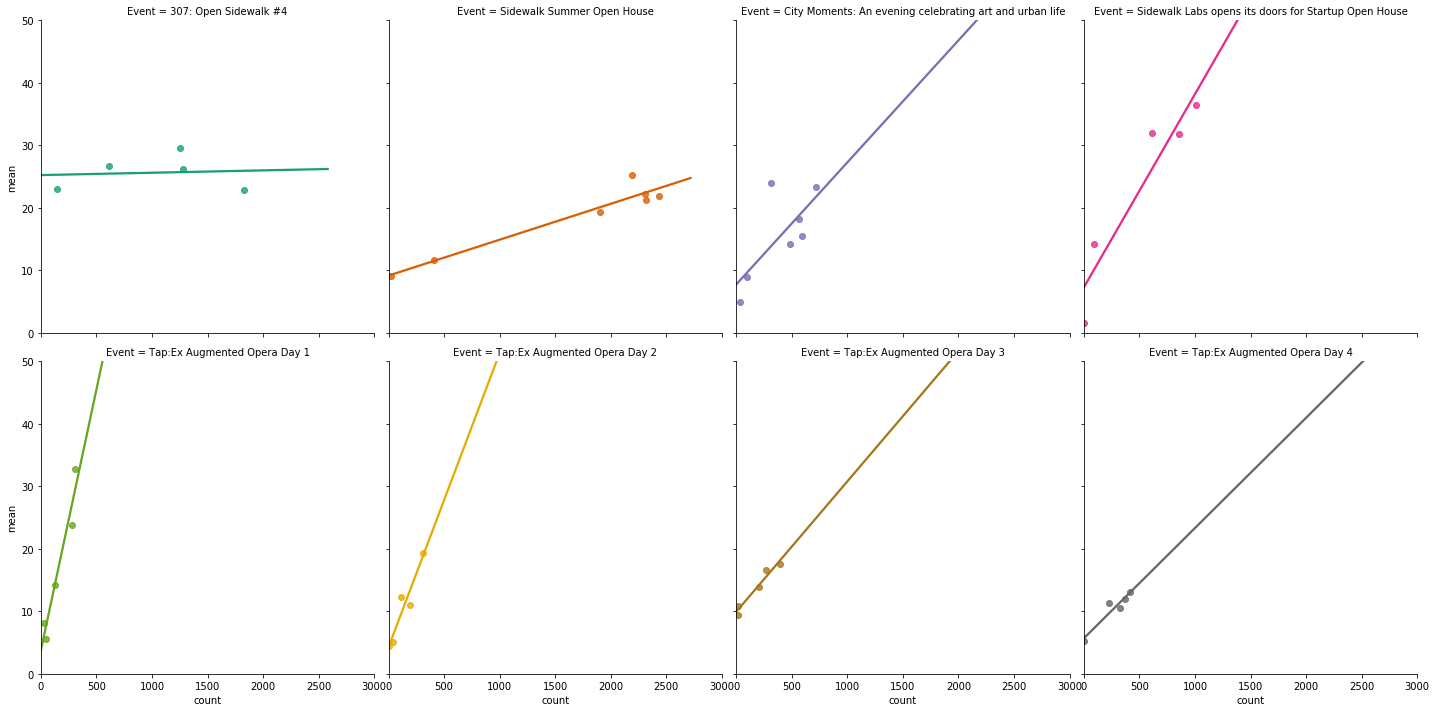

In [205]:
import seaborn as sns;
g = sns.lmplot(x="count", y="mean", hue="Event", data=feed_dwell_1h_df_event_streetscape,
               palette="Dark2", ci = None, col = "Event", col_wrap = 4)
g = g.set(xlim = (0, 3000), ylim = (0, 50))

In [158]:
feed_dwell_1d_df_streetscape = feed_dwell_1d_df[feed_dwell_1d_df['device'] == "Streetscape"]

In [183]:
def plot_dwell_time_ped_count_all_days():
    
    df = feed_dwell_1d_df_streetscape
    
    fig = make_subplots(rows = 2, cols = 1)
    
    fig.add_trace(go.Scatter(x=df['time'], y=df['mean_dwell'], 
                             name = "Dwell Time (mean)", line_color="royalblue"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['count'], 
                            name = "Pedestrian Count", line_color="dimgray"), row=2, col=1)

    df_corr = df[['count', 'mean_dwell']]
    pearson_r = df_corr.corr().iloc[0, 1]
    title = "Pearson correlation: " + str(pearson_r)
    
    fig.update_layout(height=500, width=950, title_text=title)
    fig.show()

In [184]:
plot_dwell_time_ped_count_all_days()

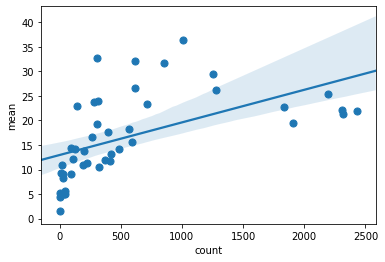

In [189]:
ax = sns.regplot(x="count", y="mean", data=feed_dwell_1h_df_event_streetscape,
                 x_estimator=np.mean)

In [202]:
feed_dwell_1h_df_normal_time = feed_dwell_1h_df[feed_dwell_1h_df["Hour"] <= 18]
feed_dwell_1h_df_normal_time = feed_dwell_1h_df_normal_time[feed_dwell_1h_df_normal_time["Hour"] >= 9]

In [204]:
df_corr = feed_dwell_1h_df_normal_time[['count', 'mean']]
pearson_r = df_corr.corr().iloc[0, 1]
pearson_r

-0.007431990864673159

## Maintenance Strategy

In [ ]:
# need hourly data so writing the query again; can combine with the previous one later
def get_dwell_by_hour(func, ID):
    '''
    func is either feedDwellTimeDistribution or zoneDwellTimeDistribution
    '''
    if func == 'feedDwellTimeDistribution':
        arg = 'serialnos: "{0}"'.format(ID)
    else:
        arg = 'zoneIds: {0}'.format(ID)
        
    query = """
    query {{
        {0}(
        {1},
        startTime: "2019-02-20T00:00:00",
        endTime: "2020-01-12T00:00:00",
        timezone: "America/New_York",
        objClasses: ["pedestrian"],
        interval: "1h"
        ){{
        edges {{
          node {{
            time
            objClass
            pct100
            pct75
            pct50
            pct25
            mean
            count
          }}
        }}
      }}
    }}
    """.format(func, arg)

    dwell = requests.post(url, json={'query': query}, 
                           headers = {'Authorization':token})
    
    df = pd.DataFrame([x['node'] for x in dwell.json()['data'][func]['edges']])
    if func == 'feedDwellTimeDistribution':
        df['device'] = ID
    else:
        df['zone'] = ID
    
    return df

In [ ]:
feed_dwell_df = pd.concat([get_dwell_by_hour('feedDwellTimeDistribution', device_ids[i]) 
                           for i in range(3)])

In [ ]:
# replace NaN with 0
feed_dwell_df = feed_dwell_df.fillna(0)

# convert time to timestamp object
feed_dwell_df['time'] = feed_dwell_df['time'].str[:-6].apply(lambda x : pd.Timestamp(x))

# add name column in addition to ID
feed_dwell_df['device_name'] = [device_dict[d] for d in feed_dwell_df.device]

In [ ]:
import datetime as dt
from pandas.api.types import CategoricalDtype
days = [(dt.datetime(2019, 3, 4) + dt.timedelta(days=x)).strftime('%a') for x in range(0, 7)]
day_type = CategoricalDtype(categories=days, ordered=True)

feed_dwell_df['day of week'] = feed_dwell_df['time'].apply(lambda x: x.strftime('%a')).astype(day_type)
feed_dwell_df['date'] = feed_dwell_df['time'].apply(lambda x: x.strftime('%Y-%m-%d'))
feed_dwell_df['hour'] = feed_dwell_df['time'].apply(lambda x: x.strftime('%H'))
feed_dwell_df['hour'] = pd.to_numeric(feed_dwell_df['hour'])

In [ ]:
daily_count = feed_dwell_df.groupby(['date', 'device_name'])['count'].max()
daily_count = pd.DataFrame(daily_count).reset_index()
daily_count['date'] = pd.to_datetime(daily_count['date'])

In [ ]:
def maintenance_df(df, device, threshold, service):
    dev_df = df[df['device_name'] == device]
    
    need_extra = []
    need_regular = []
    unmaintained = []
    visualize = []
    cumulative = 0

    for index, row in dev_df.iterrows():
        if row['count'] >= threshold:
            need_extra.append(1)
            need_regular.append(0)
            if service == 'both' or service == 'extra':
                visualize.append(row['count'])
            else:
                visualize.append(0)
            cumulative = 0

        else:
            need_extra.append(0)
            cumulative += row['count']
            if cumulative >= threshold:
                need_regular.append(1)
                if service == 'both' or service == 'regular':
                    visualize.append(cumulative)
                else:
                    visualize.append(0)
                cumulative = 0
            else:
                visualize.append(0)
                need_regular.append(0)

        unmaintained.append(cumulative)

    dev_df['need_extra'] = need_extra
    dev_df['need_regular'] = need_regular
    dev_df['unmaintained'] = unmaintained
    dev_df['visualize'] = visualize
        
    return dev_df

In [ ]:
def plot_maintenance(start_date, end_date, threshold, service):
    #df = nonzero_df
    df = daily_count
        
    plot_df = df.loc[(df.date >= pd.Timestamp(start_date)) & 
                     (df.date <= pd.Timestamp(end_date))].copy()
    
    dev1 = maintenance_df(plot_df, 'Streetscape', threshold, service)
    dev2 = maintenance_df(plot_df, 'Under Raincoat', threshold, service)
    dev3 = maintenance_df(plot_df, 'Outside', threshold, service)
    
    dev_y = ['Streetscape', 'Under Raincoat', 'Outside']
    dev_y = dev_y[::-1]
    dev_z = [dev1['visualize'], dev2['visualize'], dev3['visualize']]
    dev_z = dev_z[::-1]

    fig = go.Figure(data=go.Heatmap(
            z=dev_z,
            x=dev3['date'],
            y=dev_y,
            colorscale='Hot_r'))

    fig.update_layout(
        title='Maintenance Schedule',
        xaxis_nticks=36)
    
    fig.show()

In [ ]:
_ = interact(plot_maintenance, 
             service=widgets.Dropdown(options=['both', 'extra', 'regular'], value='both', disabled=False),
             start_date=widgets.DatePicker(value=pd.to_datetime('2019-02-20')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-01-12')),
             threshold=widgets.IntSlider(value=500, min=300, max=1000, step=100, readout_format='d')
            )

We plan to have regular maintenance once for every 500 visitors, and extra maintenance on days with more than 500 visitors on a single day. On the interactive plot, the user can select 'both' to view all the maintenance needed, or 'extra' and 'regular' to see maintenance of a specific type. 

We can see that Under Raincoat need the least maintenance, once every week during busy months, and twice or even once every month during less busy months. Streetscape needs the most maintenance. 

The color intensity represents the number of visitors for every maintenance, and the darker the colour, the more thorough the maintenance may need to be. 

The user can also change the threshold to visualize the change of maintenance freqency under different requirements, to plan the desired maintenance schedule.

In [ ]:
def plot_hour_heatmap(selected, start_date, end_date):
    df = feed_dwell_df
        
    plot_df = df.loc[(pd.to_datetime(df.date) >= pd.Timestamp(start_date)) & 
                     (pd.to_datetime(df.date) <= pd.Timestamp(end_date))].copy()
    
    fig = go.Figure()
    
    if selected == 'all':
        sub_df = plot_df.copy()
    else:
        sub_df = plot_df[plot_df['device_name'] == selected]
        
    hourly_count = sub_df.groupby(['day of week', 'hour'])['count'].mean()
    hourly_count = pd.DataFrame(hourly_count).reset_index()
        
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    days = days[::-1]
    count = []
    count = count[::-1]
    
    for day in days:
        count.append(hourly_count[hourly_count['day of week'] == day]['count'].tolist())
        
    #print(count)

    fig = go.Figure(data=go.Heatmap(
                   z=count,
                   y=days,
                   x=[0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23],
                   colorscale='YlOrRd',
                   hoverongaps = False))
    
    fig.update_layout(
        title="Pedestrian count by hour and day of week",
        xaxis = dict(
        tickmode = 'linear',
        dtick = 1,
        title = 'hour in the day')
    )
    
    fig.show()

In [ ]:
_ = interact(plot_hour_heatmap, 
             selected=widgets.Dropdown(options=['all', 'Streetscape', 'Under Raincoat', 'Outside'], 
                                       value='all', disabled=False),
             start_date=widgets.DatePicker(value=pd.to_datetime('2019-02-20')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-01-12'))
            )

Ideally, we want to plan for a regular maintenance time during the day, so we visualize the hourly count by hour and by day of the week using a calendar heatmap. For Streetscape, there are more people on Sunday afternoons, probably because of the visitors attending open hours. 

There are more activities during 8:00-20:00, and we would recommend scheduling the maintenance time during 7:00-8:00.